# Replicating [*Fingerhuth 2018*](https://arxiv.org/pdf/1810.13411.pdf)

**Protein Folding as a Self Avoiding Walk on a Lattice:**
- [*Perdomo 2008*](https://arxiv.org/pdf/0801.3625.pdf): arXiv; see published Physical Review
- [*Perdomo 2012*](https://www.nature.com/articles/srep00571): Scientific Reports Article [(SI)](https://media.nature.com/original/nature-assets/srep/2012/120813/srep00571/extref/srep00571-s1.pdf)
- [*Babbush 2013*](https://arxiv.org/pdf/1211.3422.pdf): More foundational work; most thorough explanations
- [*Babej 2018*](https://arxiv.org/pdf/1811.00713.pdf): Better explanations; D-Wave 2000Q

**QAOA:**
- [*Hadfield 2019*](https://arxiv.org/pdf/1709.03489.pdf)

[**Statistical Potential**](https://en.wikipedia.org/wiki/Statistical_potential):
- [Comparison](https://www-sciencedirect-com.stanford.idm.oclc.org/science/article/pii/S0006349518309238)
- [MJ Revisited](https://pdfs.semanticscholar.org/ac5e/eb792bf9bf1ddbb91880b38ab5fb31d2e0d1.pdf)
- [LightDock](https://github.com/brianjimenez/lightdock/blob/master/docs/README.md)

**Ramachandran:**
- [BackMAP](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6195116/)

----------------------------------

In [1]:
import itertools as it
import numpy as np
import pandas as pd
from scipy.optimize import minimize

from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H
from pyquil.paulis import exponentiate_commuting_pauli_sum

# My Code:
from lattice import plot_lattice
from hamiltonians import init_ham, H_cost, X_mixer, XY_simple

# Lattice
![planar lattice](images/lattice.png)

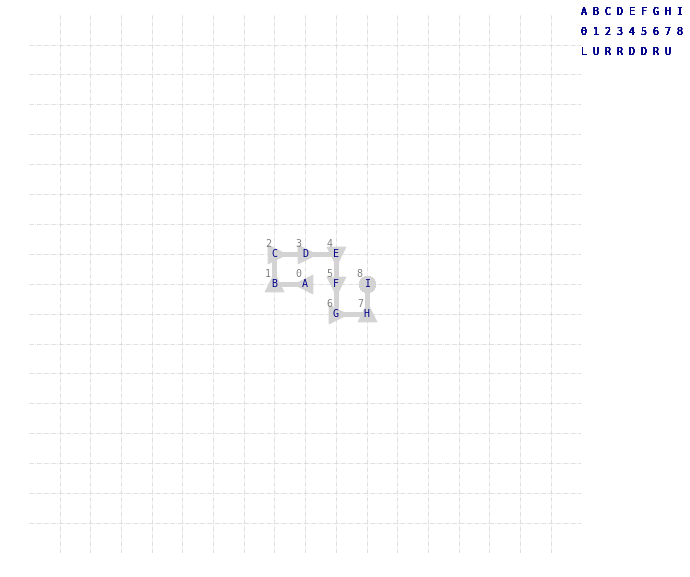

In [2]:
plot_lattice('lurrddru', 'ABCDEFGHI')

# Contact Energies
`mjh3`:
Miyazawa S, Jernigan RL. Self-consistent estimation of interresidue
protein contact energies based on an equilibrium mixture
approximation of residues. Proteins 1999;34:49-68.

Matrices from [LightDock](https://github.com/brianjimenez/lightdock/blob/6bdcb82bc16111bf8a0c9647cb90bc573fd471d8/lightdock/scoring/mj3h/data/MJ_potentials.dat)

In [3]:
d1 = pd.read_csv('mat/inds1.txt', header=None)
mjh3 = pd.read_csv('mat/mj3h.txt', delimiter=' ', header=None)
mjh3.columns = list(d1[1])
mjh3.index = list(d1[1])
mjh3

,L,F,I,M,V,W,C,Y,H,A,T,G,P,R,Q,S,N,E,D,K
L,-0.84,-0.80,-0.81,-0.70,-0.74,-0.62,-0.65,-0.55,-0.18,-0.38,-0.15,-0.16,-0.12,-0.04,-0.04,-0.02,0.04,0.17,0.27,0.22
F,-0.80,-0.88,-0.73,-0.83,-0.67,-0.68,-0.67,-0.58,-0.34,-0.36,-0.15,-0.19,-0.19,-0.05,-0.11,-0.12,-0.01,0.14,0.18,0.19
I,-0.81,-0.73,-0.74,-0.66,-0.67,-0.60,-0.64,-0.49,-0.13,-0.37,-0.15,-0.13,-0.05,0.00,-0.01,0.03,0.14,0.17,0.22,0.24
M,-0.70,-0.83,-0.66,-0.70,-0.51,-0.73,-0.61,-0.56,-0.29,-0.27,-0.11,-0.17,-0.13,0.03,-0.06,0.05,0.04,0.12,0.30,0.29
V,-0.74,-0.67,-0.67,-0.51,-0.65,-0.51,-0.59,-0.38,-0.06,-0.32,-0.07,-0.15,-0.05,0.08,0.08,0.04,0.12,0.26,0.36,0.29
W,-0.62,-0.68,-0.60,-0.73,-0.51,-0.64,-0.66,-0.49,-0.37,-0.27,-0.02,-0.25,-0.37,-0.21,-0.02,-0.01,-0.10,0.00,0.07,0.09
C,-0.65,-0.67,-0.64,-0.61,-0.59,-0.66,-1.19,-0.39,-0.36,-0.33,-0.15,-0.31,-0.18,0.08,-0.07,-0.13,-0.01,0.20,0.12,0.33
Y,-0.55,-0.58,-0.49,-0.56,-0.38,-0.49,-0.39,-0.45,-0.30,-0.20,-0.09,-0.22,-0.25,-0.25,-0.14,-0.08,-0.11,-0.08,-0.07,-0.05
H,-0.18,-0.34,-0.13,-0.29,-0.06,-0.37,-0.36,-0.30,-0.40,0.07,-0.03,0.00,0.01,0.05,0.15,0.04,0.00,0.00,-0.10,0.38
A,-0.38,-0.36,-0.37,-0.27,-0.32,-0.27,-0.33,-0.20,0.07,-0.12,0.04,-0.08,0.15,0.24,0.22,0.10,0.15,0.38,0.27,0.41


# QAOA
- [Lecture 13 Notebook](http://localhost:8888/lab/tree/lecture13.ipynb)
- [Lecture 13 Notes](https://cs269q.stanford.edu/lectures/lecture13.pdf)

In [4]:
pep = 'PSVK'       # peptide (protein)
N = len(pep)       # number amino acids
D = 2              # num dimensions

P = np.array(mjh3.loc[list(pep),list(pep)])  # subsetted contact energy matrix

from hamiltonians import H_overlap, H_pair
init_ham(N,D)

In [6]:
lambda_overlap = 1
init_state_prog = sum([H(i) for i in range(4*N-10)], Program())
h_cost = H_overlap(lambda_overlap) + sum(H_pair(P))
h_driver = X_mixer()

In [7]:
def qaoa_ansatz(betas, gammas):
    p = Program()
    p += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return p

def qaoa_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    program = init_state_prog + qaoa_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog=program, pauli_terms=h_cost)

In [8]:
result = minimize(qaoa_cost, x0=[0., -.1], method='Nelder-Mead', tol=0.001, options={'disp': True})
print()
print(result)

Optimization terminated successfully.
         Current function value: 53992109772830471297895716787085778566137122115422332602732791262296814911488.000000
         Iterations: 85
         Function evaluations: 232

 final_simplex: (array([[-0.0004375, -0.1065625],
       [-0.0004375, -0.1065625],
       [-0.0004375, -0.1065625]]), array([5.39921098e+76, 5.39921098e+76, 5.39921098e+76]))
           fun: 5.399210977283047e+76
       message: 'Optimization terminated successfully.'
          nfev: 232
           nit: 85
        status: 0
       success: True
             x: array([-0.0004375, -0.1065625])


# Enumerate Solutions
- 5 unique costs for `PSVK`

0


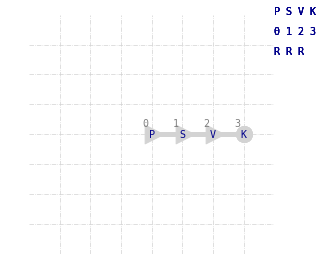

1


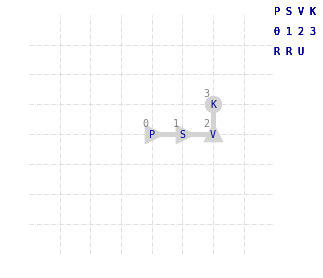

2


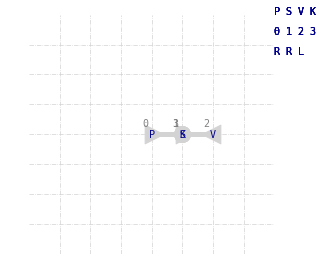

3


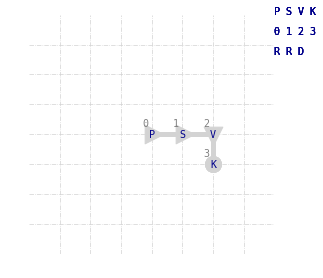

4


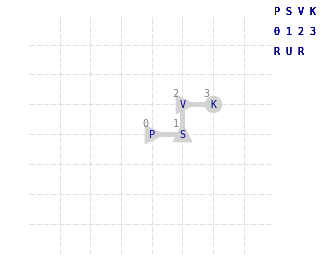

5


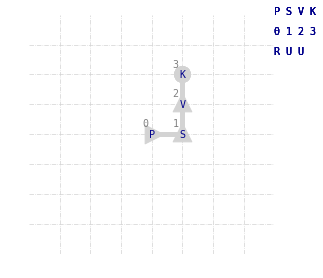

6


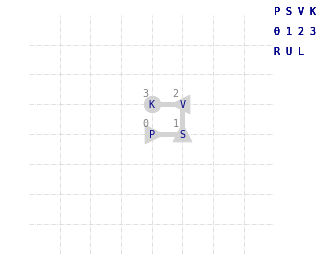

7


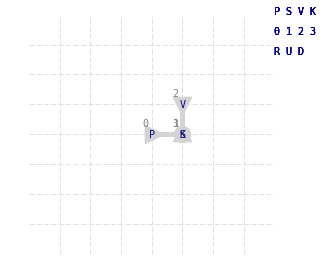

In [9]:
for i,turns in enumerate(it.product(['r'],['r','u'],['r','u','l','d'])):
    print(i)
    plot_lattice(''.join(turns),pep)

# Future Directions
**Pedagogy:**
- get it to work!
- add noise
- improve visualization to show interacting residues, bitstrings, evaluated energies
- implement remaining mixer Hamiltonians
- implement cubic lattice
- run on actual quantum computer

**Improvements:**
- lattice based on phi/psi angles
- determine maximum size of lattice for a protein of size $N$, place residues on lattice, constrain by connectivity
- denser codings instead of one-hot
- different contact energy matrices that account for solvent exposure (21x21); also see references at top
- consider orientation of residues when ascribing interaction strength
- more efficient structure:

![efficient tree](images/efficient-tree.png)